# Load the model

In [1]:
# Imports
from transformers import AlbertForTokenClassification, AutoModelForTokenClassification, pipeline
from transformers import TrainingArguments, Trainer, DataCollatorForTokenClassification
from transformers import AutoTokenizer
import torch
import json

In [2]:
version = "all_entites_1"
save_name = "ner_model_"+ version

In [3]:
label_list = ['B-Transaction_Scalability',
 'I-Transaction_Scalability',
 'I-Software_Purpose',
 'B-Development_Scalability',
 'I-Development_Scalability',
 'B-Userbase_Information',
 'I-Userbase_Information',
 'B-Data_Scalability',
 'I-CS_Name',
 'B-Software_Purpose',
 'B-Internal_Organization',
 'I-Internal_Organization',
 'I-Data_Scalability',
 'B-CS_Name',
 'O']

In [4]:
id2label = {
    str(i): label for i,label in enumerate(label_list)
}
label2id = {
    label: str(i) for i,label in enumerate(label_list)
}

In [5]:
config = json.load(open(f"{save_name}/config.json"))

In [6]:
config["id2label"] = id2label
config["label2id"] = label2id

In [7]:
json.dump(config, open(f"{save_name}/config.json","w"))

In [8]:
tokenizer = AutoTokenizer.from_pretrained("tokenizer")

In [9]:
model_fine_tuned = AutoModelForTokenClassification.from_pretrained(save_name)

# Log data

In [10]:
import matplotlib.pyplot as plt

In [11]:
# Load the list from the JSON file
with open(f'log/{save_name}.json', 'r') as f:
    loaded_list = json.load(f)

In [12]:
training_epochs = []
training_loss = []
validation_epochs = []
validation_loss = []

for i in loaded_list:
    if 'loss' in i:
        training_epochs.append(i['epoch'])
        training_loss.append(i['loss'])
    
    if 'eval_loss' in i:
        validation_epochs.append(i['epoch'])
        validation_loss.append(i['eval_loss'])

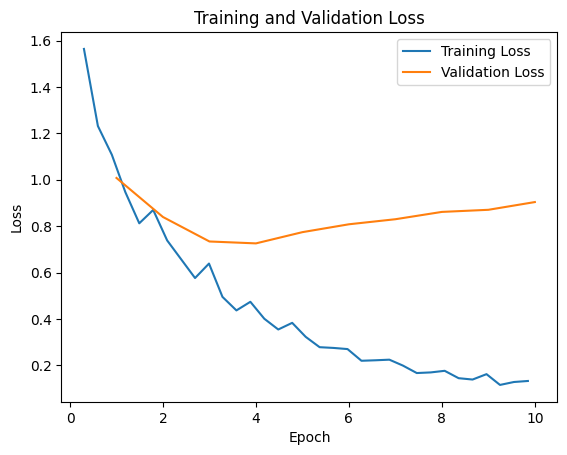

In [14]:
plt.plot(training_epochs, training_loss, label='Training Loss')
plt.plot(validation_epochs, validation_loss, label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

plt.legend()
plt.show()

# Evaluation

In [15]:
import os
from datasets import Dataset

In [16]:
# Read the JSON file

i = 0
current_dir = os.getcwd()
file_path = os.path.join(current_dir,'Labelled Data',f'dataset{i}.json')
with open(file_path, 'r') as file:
    json_data = file.read()

# Parse the JSON string into a dictionary
data = json.loads(json_data)

# Retrieve the lists from the dictionary
train_data = data['train']
test_data = data['test']

In [17]:
labels_to_ids = {'B-Transaction_Scalability': 0,
 'I-Transaction_Scalability': 1,
 'I-Software_Purpose': 2,
 'B-Development_Scalability': 3,
 'I-Development_Scalability': 4,
 'B-Userbase_Information': 5,
 'I-Userbase_Information': 6,
 'B-Data_Scalability': 7,
 'I-CS_Name': 8,
 'B-Software_Purpose': 9,
 'B-Internal_Organization': 10,
 'I-Internal_Organization': 11,
 'I-Data_Scalability': 12,
 'B-CS_Name': 13,
 'O': 14}

In [18]:
ids_to_labels = {0: 'B-Transaction_Scalability',
 1: 'I-Transaction_Scalability',
 2: 'I-Software_Purpose',
 3: 'B-Development_Scalability',
 4: 'I-Development_Scalability',
 5: 'B-Userbase_Information',
 6: 'I-Userbase_Information',
 7: 'B-Data_Scalability',
 8: 'I-CS_Name',
 9: 'B-Software_Purpose',
 10: 'B-Internal_Organization',
 11: 'I-Internal_Organization',
 12: 'I-Data_Scalability',
 13: 'B-CS_Name',
 14: 'O'}

In [19]:
label_list = ['B-Transaction_Scalability',
 'I-Transaction_Scalability',
 'I-Software_Purpose',
 'B-Development_Scalability',
 'I-Development_Scalability',
 'B-Userbase_Information',
 'I-Userbase_Information',
 'B-Data_Scalability',
 'I-CS_Name',
 'B-Software_Purpose',
 'B-Internal_Organization',
 'I-Internal_Organization',
 'I-Data_Scalability',
 'B-CS_Name',
 'O']

In [20]:
def get_texts_and_tags(BOI_list):
    # Initialize empty lists for sentences and word labels
    texts = []
    tags = []

    # Process each input string
    for input_string in BOI_list:
        lines = input_string.split("\n")
        sentence = []
        labels = []
        for line in lines:
            if line.strip() != "":
                word, label = line.split(" ")
                sentence.append(word)
                labels.append(labels_to_ids[label])
        texts.append(sentence)
        tags.append(labels)
    
    return texts, tags

In [21]:
test_texts, test_tags = get_texts_and_tags(test_data)

In [22]:
labels_to_labels = {'B-Transaction_Scalability': 'Transaction_Scalability',
 'I-Transaction_Scalability': 'Transaction_Scalability',
 'I-Software_Purpose': 'Software_Purpose',
 'B-Development_Scalability': 'Development_Scalability',
 'I-Development_Scalability': 'Development_Scalability',
 'B-Userbase_Information': 'Userbase_Information',
 'I-Userbase_Information': 'Userbase_Information',
 'B-Data_Scalability': 'Data_Scalability',
 'I-CS_Name': 'B-CS_Name',
 'B-Software_Purpose': 'Software_Purpose',
 'B-Internal_Organization': 'Internal_Organization',
 'I-Internal_Organization': 'Internal_Organization',
 'I-Data_Scalability': 'Data_Scalability',
 'B-CS_Name': 'CS_Name',
 'O': 'O'}

In [23]:
def find_sublist_index(larger_list, sublist):
    sublist_length = len(sublist)
    for i in range(len(larger_list) - sublist_length + 1):
        if larger_list[i:i+sublist_length] == sublist:
            return i
    return None


In [24]:
nlp = pipeline("ner", model=model_fine_tuned, tokenizer=tokenizer)

In [25]:
def find_entities(labels):
    entities = {}
    start_idx = None

    for idx, label in enumerate(labels):
        if label.startswith('B-'):
            # Found the start of an entity
            if start_idx is not None:
                # Add the previous entity to the dictionary
                entity = labels[start_idx].split('-')[1]
                entities[entity] = entities.get(entity,[]) + [list(range(start_idx, idx))]
            
            start_idx = idx
        elif label.startswith('I-'):
            # Continue the current entity
            if start_idx is None:
                start_idx = idx
        else:
            # End of entity
            if start_idx is not None:
                entity = labels[start_idx].split('-')[1]
                entities[entity] = entities.get(entity,[]) + [list(range(start_idx, idx))]
                start_idx = None

    # Check if there's an entity that spans till the end of the list
    if start_idx is not None:
        entity = labels[start_idx].split('-')[1]
        entities[entity] = entities.get(entity,[]) + [list(range(start_idx, len(labels)))]

    return entities

labels = ['O', 'O', 'B-ORG', 'I-ORG', 'I-ORG', 'O', 'B-PER', 'I-PER', 'O']
entity_indices = find_entities(labels)
print(entity_indices)

{'ORG': [[2, 3, 4]], 'PER': [[6, 7]]}


In [37]:
def ner_pipeline(nlp, sentence, tags):
    # NER model
    ner = nlp(sentence)
    
    # Get the tokenized input of the original sentence
    tokenized_input = tokenizer(sentence, is_split_into_words=True)
    tokens = tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
    
    # Get the word id and match the labels to the corresponding entitiy
    word_ids = tokenized_input.word_ids()
    aligned_labels = ['O' if i is None else ids_to_labels[tags[i]] for i in word_ids]
    
    entity_indices = find_entities(aligned_labels)
    
    ner_result = ['O'] * len(tokens) 

    ner_result_indices = {}
    count = 0
    for item in ner:
        part_tokens = []
        coresponding_tags = []
        for entity in item:
            coresponding_tags.append(entity['entity'])
            part_tokens.append(entity['word'])
        
        index = find_sublist_index(tokens, part_tokens)
        if index:
            all_indexes = range(index, index+len(part_tokens))
            for i, value in enumerate(all_indexes):
                ner_result[value] = coresponding_tags[i]
            
            # Adding the location of the tags
            temp = labels_to_labels[item[0]['entity']]
            ner_result_indices[temp] = ner_result_indices.get(temp, []) + [list(all_indexes)]
        

#     print(ner_result)
#     print(ner)
    
    return entity_indices, ner_result_indices, ner_result, aligned_labels
    
    

In [60]:
class Score_Container:
    def __init__(self):
        self.tp = 0
        self.tn = 0
        self.fp = 0
        self.fn = 0

In [61]:
scores_by_entity = {}
for i in set(labels_to_labels.values()):
    scores_by_entity[i] = Score_Container()

In [62]:
def get_scores(ner_result, correct_tags, ner_labels, sentence_labels):
    tp, tn, fp, fn = 0, 0, 0, 0
    
    # Making a flat list of all the indexes that contain an entity
    correct_tags_positions = []
    for n in correct_tags:
        flat_list = [item for sublist in correct_tags[n] for item in sublist]
        correct_tags_positions += flat_list
    
    ner_result_positions = []
    for n in ner_result:
        flat_list = [item for sublist in ner_result[n] for item in sublist]
        ner_result_positions += flat_list
    
    for n in ner_result:
        for sublist1 in ner_result[n]:
            if n in correct_tags:
                found = False
                for sublist2 in correct_tags[n]:
                    if set(sublist1) & set(sublist2):
                        # Assigns the correct entity in the text
                        tp += 1
                        found = True
                        scores_by_entity[n].tp += 1
                if not found and set(sublist1) & set(correct_tags_positions): 
                    # Fails to assign the correct entity but overlaps with another entity
                    fn += 1
                    scores_by_entity[n].fn += 1
                    found = True
                if not found:
                    # Assigned a label to a non-entity
                    fp += 1
                    scores_by_entity[n].fp += 1
            else:
                found = False
                if set(sublist1) & set(correct_tags_positions): 
                    # Fails to assign the correct entity but overlaps with another entity
                    fn += 1
                    scores_by_entity[n].fn += 1
                    found = True
                if not found:
                    # Assigned a label to a non-entity
                    fp += 1
                    scores_by_entity[n].fp += 1
                
                
    
    for n in correct_tags:
        for sublist2 in correct_tags[n]:
            if not set(sublist2) & set(ner_result_positions):
                fn += 1
                scores_by_entity[n].fn += 1
    
#     print(tp, tn, fp, fn)
    return tp, tn, fp, fn           
        
    

In [63]:
true_positives, true_negatives, false_positives, false_negatives = 0, 0, 0, 0
for i, sentence in enumerate(test_texts):
    correct_tags, ner_result, ner_labels, sentence_labels = ner_pipeline(nlp, sentence, test_tags[i])
    tp, tn, fp, fn = get_scores(ner_result, correct_tags , ner_labels, sentence_labels)
    true_positives += tp
    true_negatives += tn
    false_positives += fp
    false_negatives += fn
    
#     print(ner_result)
#     print(correct_tags)
#     if i > 4:
#         break

In [64]:
index = list(scores_by_entity.keys())
columns = ['tp','tn','fp','fn']

data = []
for i in scores_by_entity:
    temp = [scores_by_entity[i].tp,scores_by_entity[i].tn,scores_by_entity[i].fp,scores_by_entity[i].fn]
    data.append(temp)
    
# Create the DataFrame with specified columns and index
df = pd.DataFrame(data, columns=columns, index=index)

# Print the DataFrame
print(df)

                          tp  tn   fp   fn
Data_Scalability           0   0   25   28
O                          0   0    0    0
B-CS_Name                  0   0    0    3
Internal_Organization     38   0   13   94
CS_Name                  179   0  136  461
Software_Purpose           0   0    0  224
Transaction_Scalability    1   0   28   16
Userbase_Information      10   0   16   89
Development_Scalability    1   0   21   40


In [65]:
print(true_positives, true_negatives, false_positives, false_negatives)

229 0 239 955


In [66]:
precision = true_positives/(true_positives+false_positives)
precision

0.4893162393162393

In [67]:
recall = true_positives/(true_positives+false_negatives)
recall

0.19341216216216217